# CIRCUITO RC

$Z_{tot} = R + \frac{1}{j\omega C}$

In [105]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sys

dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')

from interpolazione import Interpolazione, final_val

dir_path = os.path.abspath('')
FICE = dir_path + '/data/' + 'RC.csv'
fr = pd.read_csv(FICE)

In [106]:
Vin = np.array(fr['Vin']) # V tensione misurata ai capi del generatore
VC = np.array(fr['VC']) # V tensione misurata con math
VR = np.array(fr['VR']) # V tensione misurata ai capi della resistenza
ν = np.array(fr['Freq (Hz)']) # Hz  impostata sul generatore
ω = 2*np.pi*ν # rad/s conversione frequenza in pulsazione

ΦR = np.array(fr['faseR (deg)'], dtype=np.float64) * (np.pi / 180) # rad fase tra VR e Vin
ΦC = np.array(fr['faseC (deg)'], dtype=np.float64) * (np.pi / 180) # rad fase tra VC e Vin

sigma_Vin = 0.04 # incertezza tensione del generatore

# errore della media presi 16 valori
sigma_VR = np.array(fr['sigmaV_R']) # incertezza tensione ai capi della resistenza
sigma_VC = np.array(fr['sigmaV_C']) # incertezza tensione ai capi del condensatore

R = 9950 # ohm resistenza nota misurata con multimetro
sigmaR = R * 0.01 # errore associato ohmmetro

# errore della media presi 16 valori (fase poco attendibile da 70deg in su)
sigma_ΦR = np.array(fr['sigmaF_R'], dtype=np.float64) * (np.pi/180.0) # rad incertezza fase tra VR e Vin
# FIXME: nel codice c'era anche un / 2, ma non so se è corretto (momentaneamente tolto)
sigma_ΦC = np.array(fr['sigmaF_C'], dtype=np.float64) * (np.pi/180.0) # rad incertezza fase tra VC e Vin

############# Calcolo funzioni di trasferimento #############

# H = Vout/Vin

modHR = VR/Vin
sigma_modHR = np.sqrt(((VR/(Vin**2))*sigma_Vin)**2 + (sigma_VR/Vin)**2)

modHC = VC/Vin
sigma_modHC = np.sqrt(((VC/(Vin**2))*sigma_Vin)**2 + (sigma_VC/Vin)**2)

## INCERTEZZE:

- $\sigma_{generatore} = 0.04$ che sono i salti (sensibilità oscilloscopio)
- $\sigma_{V_R} = $ sensibilità dello strumento (passo), cambiando scala aumenta la precisione
- $\sigma_{V_C} = $ math, meno precisa$
idem sulle fasi


### FUNZIONE DI TRASFERIMENTO $H_R(\omega)$:

- $|H_R(\omega)| = \frac{\omega RC}{\sqrt{1+\omega^2R^2C^2}}$
- $\angle H_R(\omega) = \frac{\pi}{2}-arctan(\omega RC)$

In [107]:
# definizione funzione di trasferimento
# R = 9950 # ohm
# sigmaR = R * 0.01 # errore associato ohmmetro

def mod_HR_f(ω, C): # R conosciuto
    num = ω * R * C
    den2 = 1 + (ω**2) * (R**2) * (C**2)
    return num/np.sqrt(den2)

def arg_HR_f(ω,C):
    return np.pi/2-np.arctan(ω*R*C)

$H(\omega) = V_{out}/V_{in}$

$\sigma_H = \sqrt{\left(\frac{V_{out}}{{V_{in}}^2} \cdot \sigma_{V_{in}}\right)^2 + \left(\frac{\sigma_{V_{out}}}{V_{in}}\right)^2}$

la funzione di trasferimento è data dal rapporto delle tensioni

In [108]:
# fit

C_guess = 10**-9 # usa la resistenza fissata
fit_mod_HR = Interpolazione(ω,modHR,mod_HR_f,sigma_modHR,p0=[C_guess]) # fit modulo
fit_arg_HR = Interpolazione(ω,ΦR,arg_HR_f,sigma_ΦR,p0=[C_guess]) # fit fase

print("---------------------------MODULO R -------------------------")
print('chi2: ',fit_mod_HR.rchisquare)
print("---------------------------FASE R -------------------------")
print('chi2: ',fit_arg_HR.rchisquare)
print('------------------------- VALORI RICAVATI DAL FIT MODULO HR -----------------------------')
print('C = ',final_val(fit_mod_HR.bval[0],fit_mod_HR.sigma_bval[0],decimals=3,exp=-10,udm='F'))

print('------------------------- VALORI RICAVATI DAL ARG HR -----------------------------')
print('C = ',final_val(fit_arg_HR.bval[0],fit_arg_HR.sigma_bval[0],decimals=3,exp=-10,udm='F'))

# print('R (nota) = ',final_val(R,sigmaR,decimals=3,exp=3,udm='Ω'))

---------------------------MODULO R -------------------------
chi2:  0.13
---------------------------FASE R -------------------------
chi2:  0.04
------------------------- VALORI RICAVATI DAL FIT MODULO HR -----------------------------
C =  (95.561 ± 0.925)e-10 F
------------------------- VALORI RICAVATI DAL ARG HR -----------------------------
C =  (96.619 ± 0.949)e-10 F


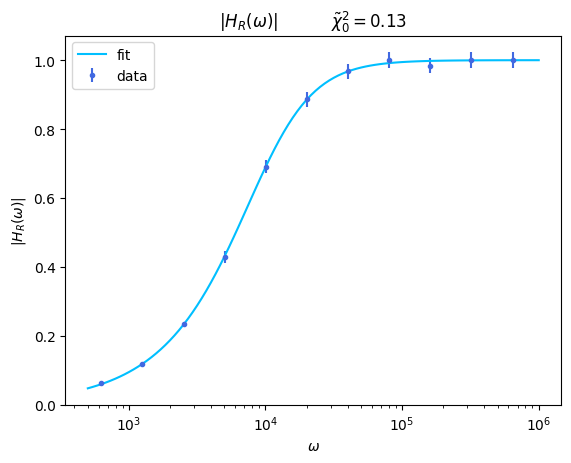

In [109]:
x = np.logspace(2.7,6,100)
y = mod_HR_f(x,*fit_mod_HR.bval)

plt.title('$|H_R(\omega)|$ \t $\\tilde{\chi}_0^2=$' + str(fit_mod_HR.rchisquare))
plt.errorbar(ω,modHR,yerr=fit_mod_HR.sigmaY,fmt='.',label='data',color='royalblue')
plt.plot(x,y,label='fit',color='deepskyblue')
plt.xlabel('$\omega$')
plt.ylabel('$|H_R(\omega)|$')
plt.xscale('log')
plt.legend()
plt.show()

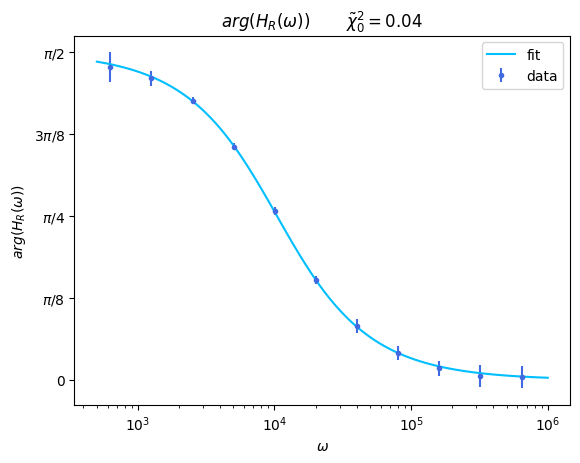

In [110]:
x = np.logspace(2.7,6,100)
y = arg_HR_f(x,*fit_arg_HR.bval)

plt.title('$arg(H_R(\omega))$ \t $\\tilde{\chi}_0^2=$' + str(fit_arg_HR.rchisquare))
plt.errorbar(ω,ΦR,yerr=fit_arg_HR.sigmaY,fmt='.',color='royalblue',label='data')
plt.plot(x,y,label='fit',color='deepskyblue')
yticks = {'$\pi/2$': np.pi/2, '$3\pi/8$': 3*np.pi/8, '$\pi/4$': np.pi/4, '$\pi/8$': np.pi/8,'0':0}
plt.yticks(list(yticks.values()), list(yticks.keys()))
plt.ylabel('$arg(H_R(\omega))$')
plt.xlabel('$\omega$')
plt.xscale('log')
plt.legend()
plt.show()

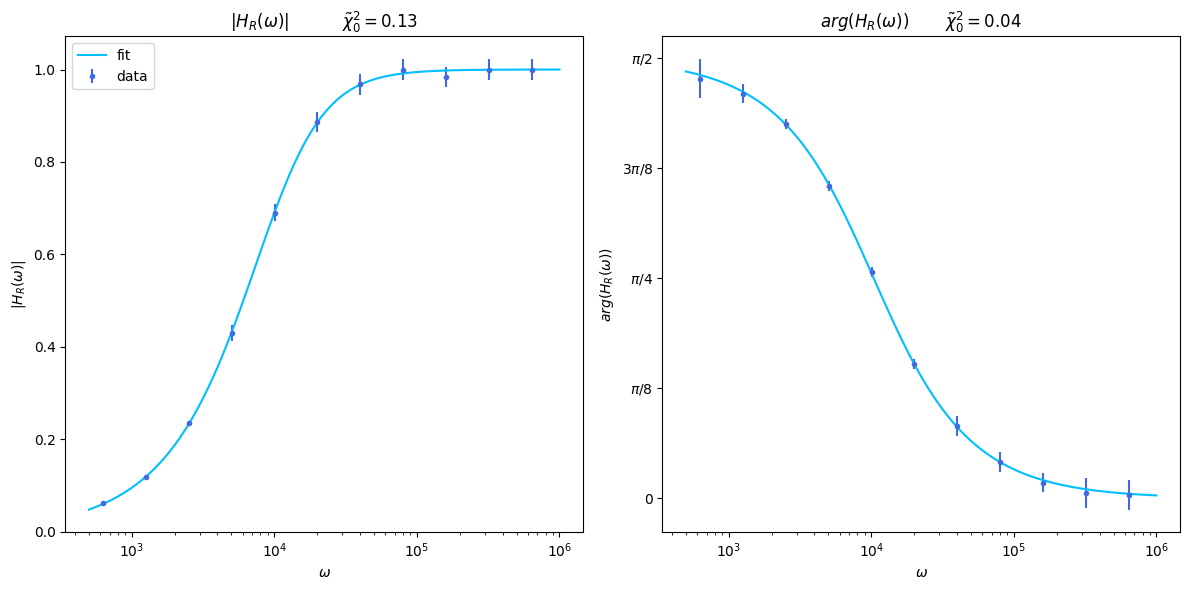

In [111]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Modulo HR
x = np.logspace(2.7, 6, 100)
y = mod_HR_f(x, *fit_mod_HR.bval)
axs[0].set_title('$|H_R(\omega)|$  \t $\\tilde{\chi}_0^2=$' + str(fit_mod_HR.rchisquare))
axs[0].errorbar(ω, modHR, yerr=fit_mod_HR.sigmaY, fmt='.', label='data', color='royalblue')
axs[0].plot(x, y, label='fit', color='deepskyblue')
axs[0].set_xscale('log')
axs[0].set_ylabel('$|H_R(\omega)|$')
axs[0].set_xlabel('$\omega$')
axs[0].legend()

# Plot 2: Argomento HR
x = np.logspace(2.7, 6, 100)
y = arg_HR_f(x, *fit_arg_HR.bval)
axs[1].set_title('$arg(H_R(\omega))$ \t $\\tilde{\chi}_0^2=$' + str(fit_arg_HR.rchisquare))
axs[1].errorbar(ω, ΦR, yerr=fit_arg_HR.sigmaY, fmt='.', color='royalblue', label='data')
axs[1].plot(x, y, color='deepskyblue', label='fit')
axs[1].set_xscale('log')
axs[1].set_ylabel('$arg(H_R(\omega))$')
axs[1].set_xlabel('$\omega$')

axs[1].set_yticks([np.pi/2,3*np.pi/8,np.pi/4,np.pi/8,0])
axs[1].set_yticklabels(['$\pi/2$','$3\pi/8$','$\pi/4$','$\pi/8$','0'])


plt.tight_layout()
plt.show()


### FUNZIONE DI TRASFERIMENTO $H_C(\omega)$:

- $|H_C(\omega)| = \frac{1}{\sqrt{1+\omega^2R^2C^2}}$
- $\angle H_C(\omega) = -arctan(\omega RC)$


In [112]:
# R = 9950 # ohm
# sigmaR = R * 0.01 # errore associato ohmmetro

def mod_HC_f(ω, C): # R conosciuto
    num = 1
    den2 = 1 + (ω**2) * (R**2) * (C**2)
    return num/np.sqrt(den2)

def arg_HC_f(ω,C):
    return -np.arctan(ω*R*C)

In [113]:
C_guess = 10**-9 # usa la resistenza fissata
fit_mod_HC = Interpolazione(ω,modHC,mod_HC_f,sigma_modHC,p0=[C_guess])
fit_arg_HC = Interpolazione(ω,ΦC,arg_HC_f,sigma_ΦC,p0=[C_guess])

print("---------------------------MODULO C-------------------------")
print('chi2: ',fit_mod_HC.rchisquare)
print("---------------------------FASE C-------------------------")
print('chi2: ',fit_arg_HC.rchisquare)
print('------------------------- VALORI RICAVATI DAL FIT MODULO HC -----------------------------')
print('C = ',final_val(fit_mod_HC.bval[0],fit_mod_HC.sigma_bval[0],decimals=3,exp=-10,udm='F'))
print('------------------------- VALORI RICAVATI DAL FIT ARG HC -----------------------------')
print('C = ',final_val(fit_arg_HC.bval[0],fit_arg_HC.sigma_bval[0],decimals=3,exp=-10,udm='F'))

# print('R (nota) = ',final_val(R,sigmaR,decimals=3,exp=3,udm='Ω'))

---------------------------MODULO C-------------------------
chi2:  0.15
---------------------------FASE C-------------------------
chi2:  0.32
------------------------- VALORI RICAVATI DAL FIT MODULO HC -----------------------------
C =  (96.229 ± 1.329)e-10 F
------------------------- VALORI RICAVATI DAL FIT ARG HC -----------------------------
C =  (93.672 ± 2.408)e-10 F


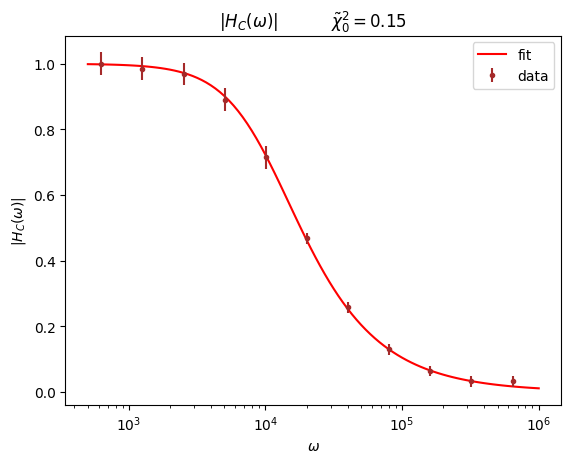

In [114]:
x = np.logspace(2.7,6,100)
y = mod_HC_f(x,*fit_mod_HC.bval)

plt.title('$|H_C(\omega)|$ \t $\\tilde{\chi}_0^2=$' + str(fit_mod_HC.rchisquare))
plt.plot(x,y,label='fit',color='red')
plt.errorbar(ω,modHC,yerr=fit_mod_HC.sigmaY,fmt='.',label='data',color='brown')
plt.xlabel('$\omega$')
plt.ylabel('$|H_C(\omega)|$')
plt.xscale('log')
plt.legend()
plt.show()

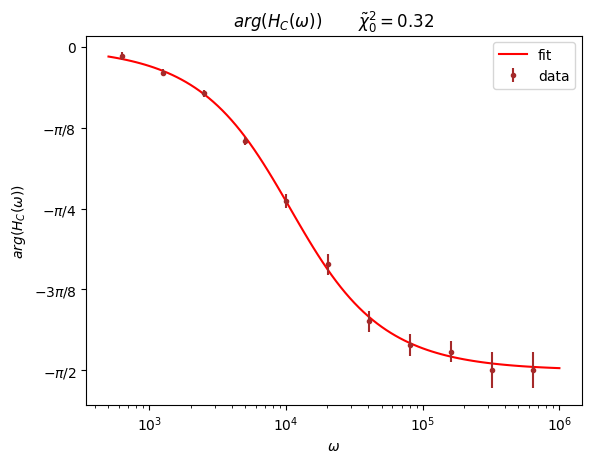

In [115]:
x = np.logspace(2.7,6,100)
y = arg_HC_f(x,*fit_arg_HC.bval)

plt.title('$arg(H_C(\omega))$  \t $\\tilde{\chi}_0^2=$' + str(fit_arg_HC.rchisquare))
plt.plot(x,y,color='red',label='fit')
plt.errorbar(ω,ΦC,yerr=fit_arg_HC.sigmaY,fmt='.',color='brown',label='data')
yticks = {'$-\pi/2$': -np.pi/2, '$-3\pi/8$': -3*np.pi/8, '$-\pi/4$': -np.pi/4, '$-\pi/8$': -np.pi/8,'0':0}
plt.yticks(list(yticks.values()), list(yticks.keys()))
plt.ylabel('$arg(H_C(\omega))$')
plt.xlabel('$\omega$')
plt.xscale('log')
plt.legend()
plt.show()

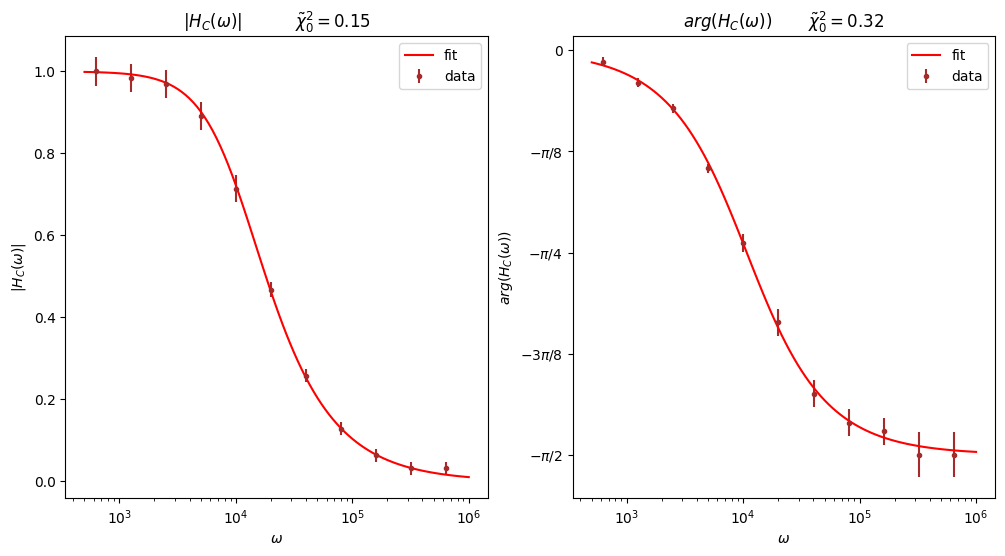

In [116]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 6))

# rappresentazione modulo HC

x = np.logspace(2.7,6,100)
y = mod_HC_f(x,*fit_mod_HC.bval)

ax1.set_title('$|H_C(\omega)|$  \t $\\tilde{\chi}_0^2=$' + str(fit_mod_HC.rchisquare))
ax1.errorbar(ω,modHC,yerr=fit_mod_HC.sigmaY,fmt='.',label='data',color='brown')
ax1.plot(x,y,label='fit',color='red')
ax1.set_xscale('log')
ax1.set_ylabel('$|H_C(\omega)|$')
ax1.set_xlabel('$\omega$')
ax1.legend()

# rappresentazione argomento HC

x = np.logspace(2.7,6,100)
y = arg_HC_f(x,*fit_arg_HC.bval)

ax2.set_title('$arg(H_C(\omega))$ \t $\\tilde{\chi}_0^2=$' + str(fit_arg_HC.rchisquare))
ax2.errorbar(ω,ΦC,yerr=fit_arg_HC.sigmaY,fmt='.',color='brown',label='data')
ax2.plot(x,y,label='fit',color='red')
ax2.set_xscale('log')
ax2.set_ylabel('$arg(H_C(\omega))$')
ax2.set_xlabel('$\omega$')
ax2.set_yticks([-np.pi/2,-3*np.pi/8,-np.pi/4,-np.pi/8,0])
ax2.set_yticklabels(['$-\pi/2$','$-3\pi/8$','$-\pi/4$','$-\pi/8$','0'])
ax2.legend()

plt.show()

# STIMA VALORE C con CONFRONTO

avendo calcolato il valore di C con differenti interpolazioni le confrontiamo mediandole per calcolare il suo valore

In [117]:
C = np.array([fit_arg_HC.bval[0], fit_mod_HC.bval[0],fit_mod_HR.bval[0],fit_arg_HR.bval[0]])
sigmaC = np.array([fit_arg_HC.sigma_bval[0], fit_mod_HC.sigma_bval[0],fit_mod_HR.sigma_bval[0],fit_arg_HR.sigma_bval[0]])
w = 1/(sigmaC**2)
C_avg = np.average(C, weights=w)
sigmaC_avg = np.sqrt(1/np.sum(w))

print('< C > = ',final_val(C_avg,sigmaC_avg,decimals=3,exp=-10,udm='F'))

< C > =  (95.967 ± 0.576)e-10 F
